# Formação Cientista de Dados - Data Science Academy
### Prevendo Customer Churn em Operadoras de Telecom
Projeto com Feedback 4

In [825]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro
import statsmodels.api as sm
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, RFE, SelectFromModel, chi2
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [826]:
dic_dados = {}

### Funções Utilitarias

In [827]:
# Gerar dicionário dos dados
# Criando dicionario de dados
def gerar_dicionario_dados():
    global dic_dados
    dic_dados = {
        'Unnamed: 0': 'Índice numérico das linhas do conjunto de dados.',
        'state': 'Estado dos EUA onde o cliente reside.',
        'account_length': 'Tempo que o cliente tem sido assinante da operadora.',
        'area_code': 'Código de área do telefone do cliente.',
        'international_plan': 'Indica se o cliente tem um plano internacional ativado (yes/no).',
        'voice_mail_plan': 'Indica se o cliente tem um plano de correio de voz ativado (yes/no).',
        'number_vmail_messages': 'Número de mensagens de correio de voz que o cliente tem.',
        'total_day_minutes': 'Total de minutos usados durante o dia.',
        'total_day_calls': 'Total de chamadas feitas durante o dia.',
        'total_day_charge': 'Total cobrado pela operadora pelo uso durante o dia.',
        'total_eve_minutes': 'Total de minutos usados durante a noite.',
        'total_eve_calls': 'Total de chamadas feitas durante a noite.',
        'total_eve_charge': 'Total cobrado pela operadora pelo uso durante a noite.',
        'total_night_minutes': 'Total de minutos usados durante a noite.',
        'total_night_calls': 'Total de chamadas feitas durante a noite.',
        'total_night_charge': 'Total cobrado pela operadora pelo uso durante a noite.',
        'total_intl_minutes': 'Total de minutos usados em chamadas internacionais.',
        'total_intl_calls': 'Total de chamadas feitas para números internacionais.',
        'total_intl_charge': 'Total cobrado pela operadora pelo uso de chamadas internacionais.',
        'number_customer_service_calls': 'Número de chamadas feitas pelo cliente ao serviço de atendimento ao cliente.',
        'churn': 'Indica se o cliente cancelou o contrato com a operadora (yes/no).'
    }
    return dic_dados

In [828]:
# Carregar dados
def carrega_dados(nome_arquivo):
    df = pd.read_csv(nome_arquivo)
    
    print('dimensões:', df.shape)
    print('colunas:', df.columns)

    # Analisando dataframe
    df.head(5)

    return df

In [829]:
# Analisar Area com maior numero de churns
def analisar_area_maior_churn(df):
    churn_por_area = df.groupby('area_code')['churn'].value_counts()

    maior_contagem = churn_por_area.max()
    area_maior_contagem = churn_por_area[churn_por_area == maior_contagem].index.get_level_values(0)[0]

    print("A área com o maior número de churns é a {}.".format(area_maior_contagem))
    return area_maior_contagem

In [830]:
# Transformar coluna area_code
def transformar_area_code(df):
    print('Valores únicos:', df.area_code.unique())
    # Aplicando regex para extrair somento o numero do texto
    df['area_code'] = df.area_code.str.extract('(\d+)')
    # Conferindo o resultado
    print('Valores modificados:', df.area_code.unique())

In [831]:
# Analisar valores unicos por coluna
def analisar_valor_unicos(df, coluna):
    for c in coluna:
        print('Valores únicos {}:'.format(c), df[c].unique())

In [832]:
# Analisar área com maior número de cancelamentos
def analisar_area_maior_churn_por_area(df, area_maior_contagem):
    df_maior_valor_churn = df.loc[(df['area_code'] == str(area_maior_contagem)) & (df['churn'] == 'yes')]
    return df_maior_valor_churn

In [833]:
# Criar gráfico com a contagem de churn e não churn para clientes com e sem plano internacional
def gerar_grafico_analisar_quantidade_churn_plano_internacional(df):
    intl_counts = df.groupby(["international_plan", "churn"]).size().unstack()

    intl_counts.index = ['Não possui', 'Possui']
    intl_counts.plot(kind="bar")

    # Configurando os eixos e a legenda
    plt.xlabel("Plano Internacional")
    plt.ylabel("Contagem")
    plt.legend(title="Churn", labels=["Não", "Sim"])
    plt.xticks(rotation=0)

    for i in range(len(intl_counts.index)):
        plt.text(x = i - 0.1, y = intl_counts.iloc[i,0] + 50, s = intl_counts.iloc[i,0], size = 10)
        plt.text(x = i + 0.1, y = intl_counts.iloc[i,1] + 50, s = intl_counts.iloc[i,1], size = 10)

    # Exibindo o gráfico
    plt.show()

In [834]:
# Gerar gráfico da distribuição dos dados para o total cobrado pela operadora entre entre cliente churn e não churn
def gerar_grafico_distribuicao_total_cobrado_por_churn(df):
    # Criando dois dataframes separados, um para churn=0 e outro para churn=1
    dados_churn_0 = df[df["churn"] == 'no']
    dados_churn_1 = df[df["churn"] == 'yes']

    # Criando dois subplots, um para churn=0 e outro para churn=1
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    # Criando o histograma para churn=0
    sns.histplot(data=dados_churn_0, x="total_charge", ax=axes[0])
    axes[0].set_title("Clientes Não Churn")

    # Criando o histograma para churn=1
    sns.histplot(data=dados_churn_1, x="total_charge", ax=axes[1])
    axes[1].set_title("Clientes Churn")

    # Exibindo os gráficos
    plt.show()
    print('É possivel visualizar que entre os clientes com churn, a maior concentração destes está em clientes que foram cobrados pela operadora em torno de 75 ~ 80, seguidos por 50 ~ 55.')

In [835]:
# Gerar gráfico para analisar a distribuição do valor total cobrado pela operadora em tempo de conta e numero de chamados para clientes com churn
def gerar_grafico_distribuicao_valor_cobrado_maior_concentracao_churn(df):
    df_maior_concentracao = df[(df['churn'] == 'yes')  & ((df['total_charge'] >= 75) & (df['total_charge'] <= 80) | (df['total_charge'] >= 50) & (df['total_charge'] <= 55))]
    df_maior_concentracao = df_maior_concentracao[['account_length', 'total_charge', 'number_customer_service_calls', 'international_plan']]
    
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize=(12, 6))

    sns.scatterplot(x='account_length', y='number_customer_service_calls', hue='total_charge', data=df_maior_concentracao, ax=ax)
    ax.set_xlabel('Tempo de conta (meses)')
    ax.set_ylabel('Número de chamadas de serviço ao cliente')
    ax.legend(title='Total Charge')
    ax.get_legend().set_title('Total cobrado pela operadora')
    ax.set_title('Distribução do valor cobrado pela operado em relação ao tempo de conta e quantidade de chamados (Maior concentração de Churn)')
    plt.show()

In [836]:
# Criando coluna total_charges para representar o valor total cobrado pela operadora
def criar_total_charge(df):
    df['total_charge'] = df.total_day_charge + df.total_eve_charge + df.total_night_charge + df.total_intl_charge
    dic_dados['total_charge'] = "Total cobrado pela operadora"
    df.head(5)
    return df

In [837]:
# Remover colunas
def remover_colunas(df, colunas):
    print('colunas que serão removidas:', colunas)
    # Analisando dados que serão excluidos
    df[colunas].head(10)
    # Removendo colunas
    return df.drop(colunas, axis=1)

In [838]:
# Aplicar de label-encoding
def aplica_label_encoding(df, lista_colunas):
    le = LabelEncoder()
    for coluna in lista_colunas:
        df[coluna] = le.fit_transform(df[coluna])
    return df

In [839]:
# Selecionando variáveis categóricas
def tratar_variaveis_categoricas(df):
    variaveis_categoricas = df.select_dtypes(include='object')
    # Analisando valores únicos das variáveis categóricas
    for v in variaveis_categoricas:
        analisar_valor_unicos(df, [v])

    print('\ncolunas modificadas:', list(variaveis_categoricas.columns))
    # Aplicando label-encoding nas variáveis categóricas
    df = aplica_label_encoding(df, variaveis_categoricas.columns)
    df[variaveis_categoricas.columns].sample(5)

    return df

In [840]:
# Analisando correlação das variáveis preditoras com a variável alvo
def gerar_matrix_correlacao(df):
    # Separando as variáveis preditoras e alvo
    variavel_alvo = df['churn']
    variaveis_preditoras = df.drop('churn', axis=1)

    # Criando a matriz de correlação
    matriz_correlacao_alvo = variaveis_preditoras.corrwith(variavel_alvo).sort_values(ascending=False)
    matriz_correlacao_alvo = pd.DataFrame({'variavel': matriz_correlacao_alvo.index, 'correlacao': matriz_correlacao_alvo.values})

    print(matriz_correlacao_alvo)

In [841]:
# Gerar gráficos de balanceamento de classes
def plot_balanceamento_classes(classe, titulo):
    classes, counts = np.unique(classe, return_counts=True)
    plt.bar(classes, counts)
    plt.xticks(classes)
    plt.xlabel('Classes')
    plt.ylabel('Número de amostras')
    plt.title(titulo)
    
    for i in range(len(classes)):
        plt.text(x = classes[i] - 0.05, y = counts[i] + 1, s = counts[i])
    
    plt.show()

In [842]:
# Selecionar melhores variaveis para o modelo
def selecionar_melhores_variaveis(x, y, quatidade_variaveis):
    logreg = LogisticRegression(max_iter=1200)
    rfe = RFE(estimator=logreg, n_features_to_select=quatidade_variaveis)
    rfe.fit(x, y)
    return x.columns[rfe.support_]

In [843]:
# Validar se possui/não possui informações
def validar_valores(valor):
    if valor > 0:
        return 1
    else:
        return 0

In [844]:
# Aplicar o SMOTE para balancear as classes
def aplicar_balanceamento_classes(variavel_alvo, variaveis_preditoras):
    smote = SMOTE(random_state=42)
    return smote.fit_resample(variavel_alvo, variaveis_preditoras)

In [845]:
# Gerar gráfico com a média de chamado em relação a clientes com churn ou não
def gerar_grafico_media_chamados_por_churn(df):
    categories = ['Não Churn', 'Churn']

    # Calcular a média de chamadas de serviço ao cliente para cada valor de churn
    churn_calls = df.groupby('churn')['number_customer_service_calls'].sum()

    # Definir as cores das barras
    colors = ['#1f77b4', '#ff7f0e']

    # Criar um gráfico de barras para mostrar as médias de chamadas de serviço ao cliente para cada valor de churn
    plt.bar(categories, churn_calls.values, color=colors)
    plt.title('Quantidade de chamadas de serviço ao cliente por churn')
    plt.xlabel('Cliente Churn')
    plt.ylabel('Quantidade de chamadas de serviço ao cliente')

    # Adicionar os valores das barras no gráfico
    for i, value in enumerate(churn_calls.values):
        plt.text(i, value, str(round(value, 2)), ha='center')

    plt.show()

In [846]:
# Gerar gráfico de Churn por área
def gerar_grafico_churn_por_area(df):
    # Criar uma tabela pivô com a contagem de "yes" e "no" por "area_code"
    df_pivot = df.pivot_table(index='area_code', columns='churn', values='state', aggfunc='count')

    # Transformar a tabela pivô em um DataFrame com as colunas "area_code", "churn" e "count"
    df_new = pd.DataFrame(df_pivot.to_records())
    df_new = df_new.rename(columns={'area_code': 'Area Code', 'no': 'Não churn', 'yes': 'Churn'})

    # Plotar um gráfico de barras com as colunas "yes" e "no" lado a lado
    ax = df_new.plot(x='Area Code', kind='bar', rot=0)

    # Adicionar rótulos de valores às barras
    for c in ax.containers:
        for r in c:
            h = r.get_height()
            ax.annotate(f'{h:.0f}', xy=(r.get_x() + r.get_width() / 2, h), 
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    # Adicionar rótulos de rótulos à base das barras
    ax.set_xlabel('Área')
    ax.set_ylabel('Quantidade de Churns')
    ax.set_title('Quantidade de Churns por Area')

    # Ajustar o tamanho do gráfico
    fig = ax.get_figure()
    fig.set_size_inches(8, 6)

    # Mostrar o gráfico
    plt.show()

In [847]:
# Criar gráfico de distribuição do dados e desvio padrão
def gerar_grafico_distribuicao_desvio_padrao(df):
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))
    axs = axs.flatten()

    colunas = ['state', 'account_length', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
    'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls', 'total_charge']

    for i, coluna in enumerate(colunas):        
        axs[i].hist(df[coluna], bins=25, density=True, alpha=0.6, color='g')
        mu, std = stats.norm.fit(df[coluna])
        xmin, xmax = axs[i].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mu, std)
        axs[i].plot(x, p, 'k', linewidth=2)
        axs[i].set_title(coluna)

    plt.tight_layout()
    plt.show()

In [848]:
def aplicar_padronizacao_dados(df):
    # seleciona as variáveis a serem padronizadas
    variaveis = ['account_length', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
                 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
                 'number_customer_service_calls']

    # cria uma cópia do dataset
    dados_padronizados = df.copy()

    # aplica a padronização nas variáveis selecionadas
    scaler = StandardScaler()
    dados_padronizados[variaveis] = scaler.fit_transform(dados_padronizados[variaveis])
    return dados_padronizados

In [849]:
# Selecionar melhores variáveis para o modelo
def listar_melhores_variaveis_modelo(preditoras, alvo):
    vars_selecionadas = ['international_plan', 'total_charge', 'number_customer_service_calls',
                         'total_day_minutes', 'total_day_charge', 'number_vmail_messages', 'voice_mail_plan']
    return vars_selecionadas

In [850]:
# Treinando o modelo
def treinar_modelo(variaveis_selecionadas, preditoras, alvo):
    # Selecionando apenas as variáveis necessárias
    X = preditoras[variaveis_selecionadas]
    y = alvo

    # Dividindo os dados em conjunto de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Criando uma instância do modelo de regressão logística com o valor de C ótimo encontrado pelo GridSearchCV
    model = LogisticRegression(C=1, penalty='l2', solver='newton-cg')

    # Treinando o modelo
    model.fit(X_train, y_train)

    return model, X_train, X_test, y_train, y_test

In [851]:
# Avaliando as predições do modelo
def avaliar_modelo(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)

    print('Acurácia: {:.2f}%'.format(accuracy * 100))
    print('Precisão: {:.2f}%'.format(precision * 100))
    print('Recall: {:.2f}%'.format(recall * 100))
    print('F1-score: {:.2f}%'.format(f1 * 100))
    print('AUC-ROC: {:.2f}%'.format(auc_roc * 100))

### Coleta e pré-processamento de dados

Criando dicionário dos dados

In [852]:
dicionario = gerar_dicionario_dados()
dicionario

{'Unnamed: 0': 'Índice numérico das linhas do conjunto de dados.',
 'state': 'Estado dos EUA onde o cliente reside.',
 'account_length': 'Tempo que o cliente tem sido assinante da operadora.',
 'area_code': 'Código de área do telefone do cliente.',
 'international_plan': 'Indica se o cliente tem um plano internacional ativado (yes/no).',
 'voice_mail_plan': 'Indica se o cliente tem um plano de correio de voz ativado (yes/no).',
 'number_vmail_messages': 'Número de mensagens de correio de voz que o cliente tem.',
 'total_day_minutes': 'Total de minutos usados durante o dia.',
 'total_day_calls': 'Total de chamadas feitas durante o dia.',
 'total_day_charge': 'Total cobrado pela operadora pelo uso durante o dia.',
 'total_eve_minutes': 'Total de minutos usados durante a noite.',
 'total_eve_calls': 'Total de chamadas feitas durante a noite.',
 'total_eve_charge': 'Total cobrado pela operadora pelo uso durante a noite.',
 'total_night_minutes': 'Total de minutos usados durante a noite.',


Carregando dados

In [853]:
dados = carrega_dados("datasets/train.csv")

dimensões: (3333, 21)
colunas: Index(['Unnamed: 0', 'state', 'account_length', 'area_code',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'churn'],
      dtype='object')


### Análise exploratória

Analisando área com maior quantidade de churn

In [854]:
area_maior_contagem = analisar_area_maior_churn(dados)

A área com o maior número de churns é a area_code_415.


Analisando a quantidade de chamados por clientes churn ou não

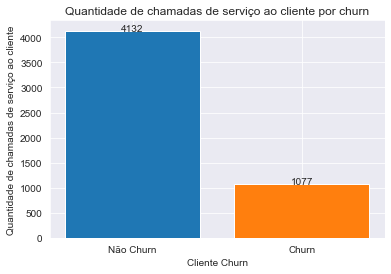

In [855]:
gerar_grafico_media_chamados_por_churn(dados)

Analisando área com maior quantidade de churn

In [856]:
df_maior_valor_churn = analisar_area_maior_churn_por_area(dados, area_maior_contagem)
print('dimenssões:', df_maior_valor_churn.shape)
print('No dataset foi filtrado somente os dados da área onde apresenta maio contidade de churn.')
df_maior_valor_churn.head(5)

dimenssões: (236, 21)
No dataset foi filtrado somente os dados da área onde apresenta maio contidade de churn.


,Unnamed: 0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
10,11,IN,65,area_code_415,no,no,0,129.1,137,21.95,...,83,19.42,208.8,111,9.40,12.7,6,3.43,4,yes
15,16,NY,161,area_code_415,no,no,0,332.9,67,56.59,...,97,27.01,160.6,128,7.23,5.4,9,1.46,4,yes
48,49,ID,119,area_code_415,no,no,0,159.1,114,27.05,...,117,19.66,143.2,91,6.44,8.8,3,2.38,5,yes
54,55,WY,87,area_code_415,no,no,0,151.0,83,25.67,...,116,18.67,203.9,127,9.18,9.7,3,2.62,5,yes
76,77,DC,82,area_code_415,no,no,0,300.3,109,51.05,...,100,15.39,270.1,73,12.15,11.7,4,3.16,0,yes


Analisando valores únicos

In [857]:
analisar_valor_unicos(dados, ['area_code', 'number_vmail_messages', 'number_customer_service_calls'])

Valores únicos area_code: ['area_code_415' 'area_code_408' 'area_code_510']
Valores únicos number_vmail_messages: [25 26  0 24 37 27 33 39 30 41 28 34 46 29 35 21 32 42 36 22 23 43 31 38
 40 48 18 17 45 16 20 14 19 51 15 11 12 47  8 44 49  4 10 13 50  9]
Valores únicos number_customer_service_calls: [1 0 2 3 4 5 7 9 6 8]


Analisando clientes churn e não churn para clientes com e sem plano internacional

Neste grafico podemos perceber que a relação de clientes churn com plano internacional é de 2,76%, enquanto clientes sem plano internacional é presentado por 100%.
 Ou seja, a taxa de de clientes com plano internacional + churn é bem maior, o que requer uma atenção especial.


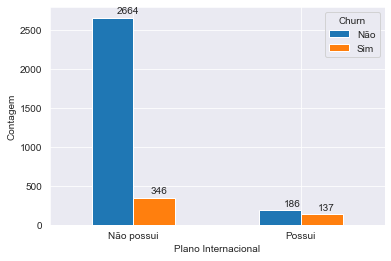

In [858]:
print('Neste grafico podemos perceber que a relação de clientes churn com plano internacional é de 2,76%, enquanto clientes sem plano internacional é presentado por 100%.\n \
Ou seja, a taxa de de clientes com plano internacional + churn é bem maior, o que requer uma atenção especial.')
gerar_grafico_analisar_quantidade_churn_plano_internacional(dados)

### Pré-processamento do dados

Gerarando a coluna "total_charge"

In [859]:
dados = criar_total_charge(dados)
print('Valores gerados:', list(dados['total_charge'].head(5)))
print('Descrição da coluna total_charge:', dicionario['total_charge'])

Valores gerados: [75.56, 59.24000000000001, 62.290000000000006, 66.8, 52.089999999999996]
Descrição da coluna total_charge: Total cobrado pela operadora


Gerando gráfico da distribuição dos dados para o total cobrado pela operadora entre entre cliente churn e não churn

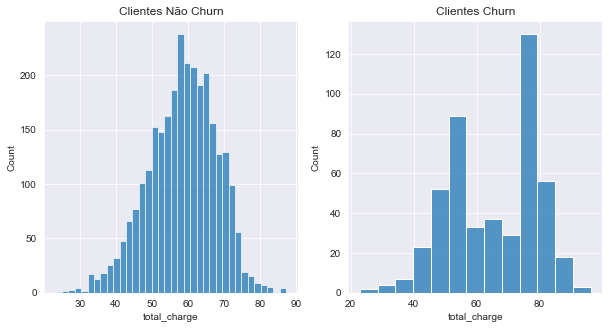

É possivel visualizar que entre os clientes com churn, a maior concentração destes está em clientes que foram cobrados pela operadora em torno de 75 ~ 80, seguidos por 50 ~ 55.


In [860]:
gerar_grafico_distribuicao_total_cobrado_por_churn(dados)

Gerando gráfico com a distribuição do total cobrado em relação a numeros de chamados e tempo de conta

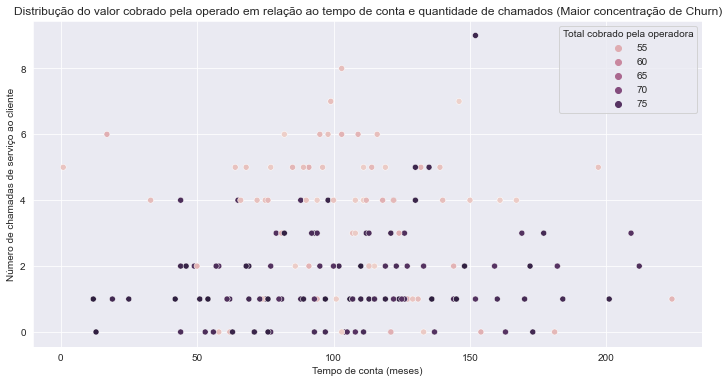

In [861]:
gerar_grafico_distribuicao_valor_cobrado_maior_concentracao_churn(dados)

Removendo colunas desnecessárias

In [862]:
dados = remover_colunas(dados, ['Unnamed: 0'])

colunas que serão removidas: ['Unnamed: 0']


Aplicando label-encoding

In [863]:
dados = tratar_variaveis_categoricas(dados)

Valores únicos state: ['KS' 'OH' 'NJ' 'OK' 'AL' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY'
 'ID' 'VT' 'VA' 'TX' 'FL' 'CO' 'AZ' 'SC' 'NE' 'WY' 'HI' 'IL' 'NH' 'GA'
 'AK' 'MD' 'AR' 'WI' 'OR' 'MI' 'DE' 'UT' 'CA' 'MN' 'SD' 'NC' 'WA' 'NM'
 'NV' 'DC' 'KY' 'ME' 'MS' 'TN' 'PA' 'CT' 'ND']
Valores únicos area_code: ['area_code_415' 'area_code_408' 'area_code_510']
Valores únicos international_plan: ['no' 'yes']
Valores únicos voice_mail_plan: ['yes' 'no']
Valores únicos churn: ['no' 'yes']

colunas modificadas: ['state', 'area_code', 'international_plan', 'voice_mail_plan', 'churn']


Gerando matrix de correlação

In [864]:
gerar_matrix_correlacao(dados)

                         variavel  correlacao
0              international_plan    0.259852
1                    total_charge    0.231549
2   number_customer_service_calls    0.208750
3               total_day_minutes    0.205151
4                total_day_charge    0.205151
5               total_eve_minutes    0.092796
6                total_eve_charge    0.092786
7               total_intl_charge    0.068259
8              total_intl_minutes    0.068239
9              total_night_charge    0.035496
10            total_night_minutes    0.035493
11                total_day_calls    0.018459
12                 account_length    0.016541
13                total_eve_calls    0.009233
14                          state    0.007780
15              total_night_calls    0.006141
16                      area_code    0.003256
17               total_intl_calls   -0.052844
18          number_vmail_messages   -0.089728
19                voice_mail_plan   -0.102148


Analisando balanceamento de classes

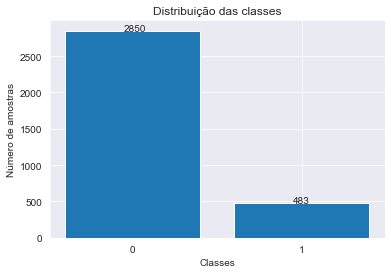

In [865]:
plot_balanceamento_classes(dados['churn'], 'Distribuição das classes')

Aplicando balanceamento de classes

In [866]:
dados_treino, dados_teste = aplicar_balanceamento_classes(dados.drop('churn', axis=1), dados['churn'])

Analisando classes após aplica o balanceamento

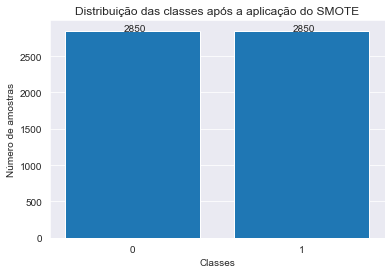

In [867]:
plot_balanceamento_classes(dados_teste, 'Distribuição das classes após a aplicação do SMOTE')

Analisando distribuição dos dados e desvio padrão das variáveis

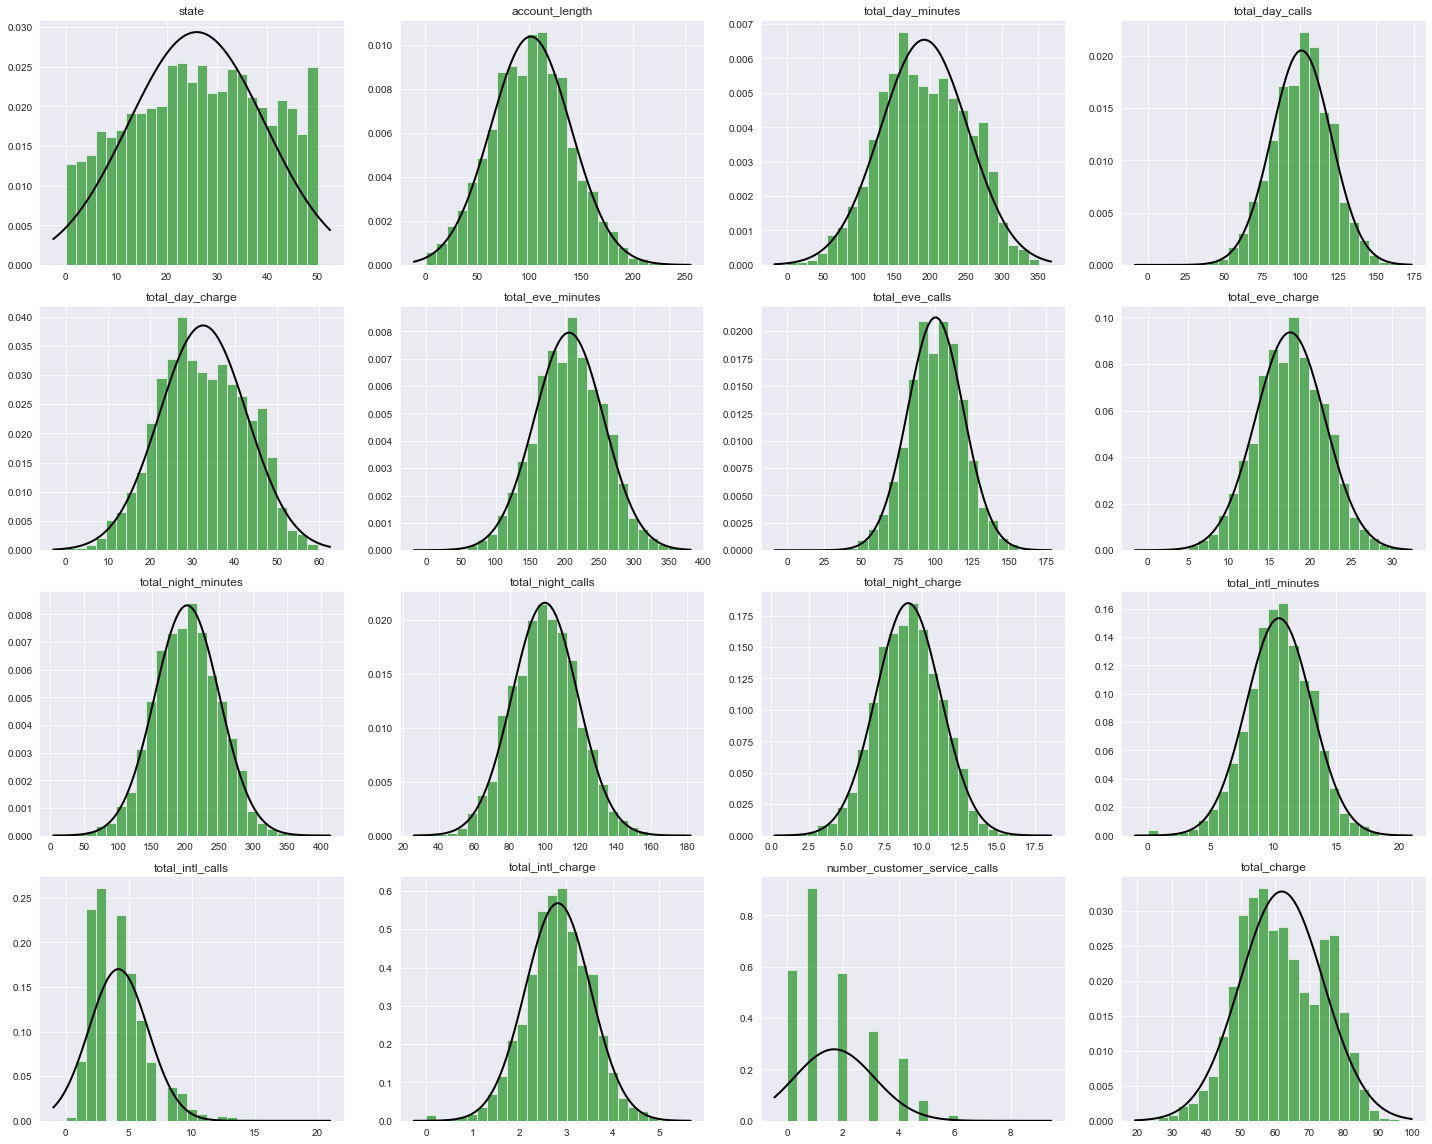

In [868]:
gerar_grafico_distribuicao_desvio_padrao(dados_treino)

Aplicando padronização nos dados

In [869]:
dados_treino = aplicar_padronizacao_dados(dados_treino)

Aplicando engenharia de atributos

In [870]:
variaveis_selecionadas = listar_melhores_variaveis_modelo(dados_treino, dados_teste)
print('Aqui foram tentadas algumas técnicas de seleção de variáveis, porém optei por selecionar as variáveis baseado na matrix de correção.')
print('Variáveis selecionadas para o modelo:\n', variaveis_selecionadas)

Aqui foram tentadas algumas técnicas de seleção de variáveis, porém optei por selecionar as variáveis baseado na matrix de correção.
Variáveis selecionadas para o modelo:
 ['international_plan', 'total_charge', 'number_customer_service_calls', 'total_day_minutes', 'total_day_charge', 'number_vmail_messages', 'voice_mail_plan']


Treinando o modelo

In [871]:
modelo, X_train, X_test, y_train, y_test = treinar_modelo(variaveis_selecionadas, dados_treino, dados_teste)

Realizando predições com o modelo

In [872]:
y_pred = modelo.predict(X_test)

Avaliando o modelo

In [873]:
avaliar_modelo(modelo, X_test, y_test)

Acurácia: 73.57%
Precisão: 71.46%
Recall: 75.60%
F1-score: 73.47%
AUC-ROC: 80.04%
